### Escopo para cálculo de parâmetros da aba Maturação 

In [65]:
# Input de dados de pirólise (leitura de planilha .csv)
# Agrupamento de dados (cluster)
# Cálculo de COTa
# Cálculo de IHa = 100 x (S2/(COTa))
# Calculo de Tr sem vitrinita: (IHa - IH)/ IHa
# Cálculo de Ro a partir de Tmax: Ro calculada = (0,0180 x Tmax) - 7,16
# Classificação do querogênio
# Cálculo de Tr por Ro e tipo de querogênio
# Normalização dos valores de Tr na curva log (ln)
# Cálculo de TOC0, S20 e IH0
# Gráficos
# Comparação entre os resultados de Tr (Ro x IH)  

##### Dependências

In [66]:
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

##### Customização dos gráficos

In [67]:
# keys = plt.rcParams.keys()
# print(keys)
# 'font.sans-serif': "Verdana",

custom_style = {
    'figure.figsize': (8, 6),
    'font.family':'sans-serif',
    'axes.facecolor': 'lightgray',
    'figure.facecolor':'silver',
    'lines.linewidth': 2,
    'scatter.marker': 'o',
    'font.size': 9,
    'axes.grid': True
    }

##### Input de dados de pirólise (leitura de planilha .csv)

In [68]:
df = pd.read_csv("Poços_Marinho/1-ALS-2-AL.csv")
df

,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO
0,579.8,2.50,0.32,6.85,1.22,430.0,NaN,274.00,48.80
1,597.8,2.51,0.29,7.13,1.27,429.0,NaN,284.06,50.60
2,615.8,2.18,0.22,6.05,1.26,430.0,NaN,277.52,57.80
3,633.8,2.06,0.26,5.28,1.10,430.0,NaN,256.31,53.40
4,651.8,1.29,0.17,1.76,1.36,428.0,NaN,136.43,105.43
...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,NaN,45.83,26.39
133,3303.8,0.26,0.10,0.10,0.30,NaN,NaN,38.46,115.38
134,3336.8,0.72,0.20,0.20,0.20,NaN,NaN,27.78,27.78


##### Agrupamento por parâmetros de pirólise

/home/rodrigo/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


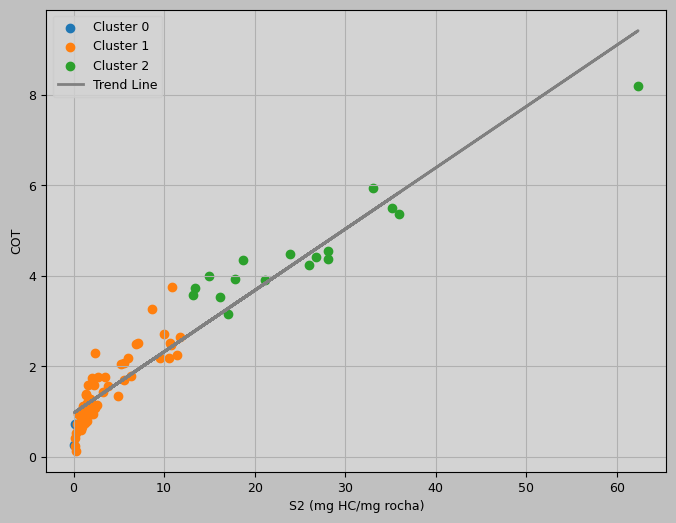

,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster
0,579.8,2.50,0.32,6.85,1.22,430.0,NaN,274.00,48.80,1
1,597.8,2.51,0.29,7.13,1.27,429.0,NaN,284.06,50.60,1
2,615.8,2.18,0.22,6.05,1.26,430.0,NaN,277.52,57.80,1
3,633.8,2.06,0.26,5.28,1.10,430.0,NaN,256.31,53.40,1
4,651.8,1.29,0.17,1.76,1.36,428.0,NaN,136.43,105.43,1
...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
132,3288.8,0.72,0.20,0.33,0.19,443.0,NaN,45.83,26.39,1
133,3303.8,0.26,0.10,0.10,0.30,NaN,NaN,38.46,115.38,0
134,3336.8,0.72,0.20,0.20,0.20,NaN,NaN,27.78,27.78,0


In [69]:
# Number of clusters you want to create
num_clusters = 3

# Extract the columns for clustering

X = df[["COT","S1","S2","S3","Tmax"]].fillna(0)

# Optional: Scale the data (if needed)
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Apply k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)  # Use X_scaled if you scaled the data, otherwise use X

# Get cluster assignments and centroids
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Add cluster labels to the original data frame
df['Cluster'] = cluster_labels

# Scatter plot
plt.figure(figsize=(8, 6))

# Plot data points for each cluster
for cluster_id in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_id]
    plt.scatter(cluster_data["S2"], cluster_data["COT"], label=f'Cluster {cluster_id}')

# Extract data from DataFrame
df1=df.dropna(subset=["COT","S2"])
x_data = df1['S2'].values.reshape(-1, 1)
y_data = df1['COT'].values

# Fit linear regression model
model = LinearRegression()
model.fit(x_data, y_data)

# Get the slope (coefficient) and y-intercept of the trend line
slope = model.coef_[0]
intercept = model.intercept_


# Plot the trend line
plt.plot(x_data, model.predict(x_data), color='gray', label='Trend Line')

plt.xlabel("S2 (mg HC/mg rocha)")
plt.ylabel("COT")
plt.title('')
plt.legend()
plt.grid(True)
plt.style.use(custom_style)
plt.show()
df

##### Equação de regressão linear para cada cluster

models = {}

for cluster_id in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_id]
    x_values = cluster_data[["S2"]].fillna(value=0)
    y_values = cluster_data["COT"]
    model = LinearRegression()
    model.fit(x_values, y_values)
    models[cluster_id] = model

# Print the linear regression equations for each cluster
for cluster_id, model in models.items():
    slope = model.coef_[0]
    intercept = model.intercept_
    print(f"Cluster {cluster_id} - y = {slope:.2f} * x + {intercept:.2f}")
    dic={cluster_id:intercept}
    print(dic)

##### Cálculo de COT ativo utilizando regressão linear

In [70]:
#Filtro para Valores de COTa < 0
df["COTa"]= df["COT"]-intercept
COT_cor=[]
for i in df["COTa"]:
    if i >= 0:
        COT_cor.append(i)
    else:
        COT_cor.append(0)
df["COTa"]= COT_cor
df
    
        

,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster,COTa
0,579.8,2.50,0.32,6.85,1.22,430.0,NaN,274.00,48.80,1,1.529706
1,597.8,2.51,0.29,7.13,1.27,429.0,NaN,284.06,50.60,1,1.539706
2,615.8,2.18,0.22,6.05,1.26,430.0,NaN,277.52,57.80,1,1.209706
3,633.8,2.06,0.26,5.28,1.10,430.0,NaN,256.31,53.40,1,1.089706
4,651.8,1.29,0.17,1.76,1.36,428.0,NaN,136.43,105.43,1,0.319706
...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000
132,3288.8,0.72,0.20,0.33,0.19,443.0,NaN,45.83,26.39,1,0.000000
133,3303.8,0.26,0.10,0.10,0.30,NaN,NaN,38.46,115.38,0,0.000000
134,3336.8,0.72,0.20,0.20,0.20,NaN,NaN,27.78,27.78,0,0.000000


##### Cálculo de IH0ativo
* IHa = 100 x (S2/(COTa))

In [71]:
IHa = 100*(df["S2"]/df["COTa"])
IHa_cor=[]
for i in IHa:
    if i<0:
        IHa_cor.append(0)
    elif i>=0 or i<=999:
        IHa_cor.append(i)
    else:
        IHa_cor.append(999)
df["IH0a"]= IHa_cor
df

,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster,COTa,IH0a
0,579.8,2.50,0.32,6.85,1.22,430.0,NaN,274.00,48.80,1,1.529706,447.798589
1,597.8,2.51,0.29,7.13,1.27,429.0,NaN,284.06,50.60,1,1.539706,463.075545
2,615.8,2.18,0.22,6.05,1.26,430.0,NaN,277.52,57.80,1,1.209706,500.121691
3,633.8,2.06,0.26,5.28,1.10,430.0,NaN,256.31,53.40,1,1.089706,484.534548
4,651.8,1.29,0.17,1.76,1.36,428.0,NaN,136.43,105.43,1,0.319706,550.506502
...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,999.000000
132,3288.8,0.72,0.20,0.33,0.19,443.0,NaN,45.83,26.39,1,0.000000,inf
133,3303.8,0.26,0.10,0.10,0.30,NaN,NaN,38.46,115.38,0,0.000000,inf
134,3336.8,0.72,0.20,0.20,0.20,NaN,NaN,27.78,27.78,0,0.000000,inf


##### Calculo da Taxa de Transformação sem Ro (IH)
* (IHa - IH)/ IHa

In [72]:
df["Taxa de Transformação (IH)"] = ((df["IH0a"]-df["IH"])/df["IH0a"])
df

,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster,COTa,IH0a,Taxa de Transformação (IH)
0,579.8,2.50,0.32,6.85,1.22,430.0,NaN,274.00,48.80,1,1.529706,447.798589,0.388118
1,597.8,2.51,0.29,7.13,1.27,429.0,NaN,284.06,50.60,1,1.539706,463.075545,0.386580
2,615.8,2.18,0.22,6.05,1.26,430.0,NaN,277.52,57.80,1,1.209706,500.121691,0.445095
3,633.8,2.06,0.26,5.28,1.10,430.0,NaN,256.31,53.40,1,1.089706,484.534548,0.471018
4,651.8,1.29,0.17,1.76,1.36,428.0,NaN,136.43,105.43,1,0.319706,550.506502,0.752174
...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,999.000000,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,NaN,45.83,26.39,1,0.000000,inf,NaN
133,3303.8,0.26,0.10,0.10,0.30,NaN,NaN,38.46,115.38,0,0.000000,inf,NaN
134,3336.8,0.72,0.20,0.20,0.20,NaN,NaN,27.78,27.78,0,0.000000,inf,NaN


##### Cálculo de Ro a partir de Tmax
* Ro calculada = (0,0180 x Tmax) - 7,16

In [73]:
df["Ro (calculada)"] = (0.0180*df["Tmax"])-7.16
Roc_cor=[]
for i in df["Ro (calculada)"]:
    if i<0:
        Roc_cor.append(0)
    else:
        Roc_cor.append(i)
df["Ro (calculada)"]=Roc_cor
df

,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster,COTa,IH0a,Taxa de Transformação (IH),Ro (calculada)
0,579.8,2.50,0.32,6.85,1.22,430.0,NaN,274.00,48.80,1,1.529706,447.798589,0.388118,0.580
1,597.8,2.51,0.29,7.13,1.27,429.0,NaN,284.06,50.60,1,1.539706,463.075545,0.386580,0.562
2,615.8,2.18,0.22,6.05,1.26,430.0,NaN,277.52,57.80,1,1.209706,500.121691,0.445095,0.580
3,633.8,2.06,0.26,5.28,1.10,430.0,NaN,256.31,53.40,1,1.089706,484.534548,0.471018,0.580
4,651.8,1.29,0.17,1.76,1.36,428.0,NaN,136.43,105.43,1,0.319706,550.506502,0.752174,0.544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,999.000000,NaN,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,NaN,45.83,26.39,1,0.000000,inf,NaN,0.814
133,3303.8,0.26,0.10,0.10,0.30,NaN,NaN,38.46,115.38,0,0.000000,inf,NaN,NaN
134,3336.8,0.72,0.20,0.20,0.20,NaN,NaN,27.78,27.78,0,0.000000,inf,NaN,NaN


#### Classificação do querogênio
* Tipo I: {IH > 600} ___ {S1/S3 > 15}
* Tipo II: {IH > 300 and IH <= 600} ___ {S1/S3 > 10 and S1/S3 <15}
* Tipo II/III: {IH > 200 and IH <=300} ___ {S1/S3 > 5 and S1/S3 < 10]
* Tipo III: {IH > 50 and IH <= 200} ___ {S1/S3 > 1 and S1/S3 < 5}
* Tipo IV: {IH <= 50} ___ {S1/S3 > 1}

In [74]:

K = []
for i in df["IH"]:
    if i > 600:
        a="Tipo I"
    elif i > 300 and i <=600:
        a="Tipo II"
    elif i > 200 and i <= 300:
        a="Tipo II/III"
    elif i > 50 and i <= 200:
        a="Tipo III"
    elif i>0 and i<=50:
        a="Tipo IV"
    else:
        a=""
    K.append(a)
querogênio=pd.DataFrame(K)
df["Querogênio"]=querogênio
df


,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster,COTa,IH0a,Taxa de Transformação (IH),Ro (calculada),Querogênio
0,579.8,2.50,0.32,6.85,1.22,430.0,NaN,274.00,48.80,1,1.529706,447.798589,0.388118,0.580,Tipo II/III
1,597.8,2.51,0.29,7.13,1.27,429.0,NaN,284.06,50.60,1,1.539706,463.075545,0.386580,0.562,Tipo II/III
2,615.8,2.18,0.22,6.05,1.26,430.0,NaN,277.52,57.80,1,1.209706,500.121691,0.445095,0.580,Tipo II/III
3,633.8,2.06,0.26,5.28,1.10,430.0,NaN,256.31,53.40,1,1.089706,484.534548,0.471018,0.580,Tipo II/III
4,651.8,1.29,0.17,1.76,1.36,428.0,NaN,136.43,105.43,1,0.319706,550.506502,0.752174,0.544,Tipo III
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,999.000000,NaN,NaN,
132,3288.8,0.72,0.20,0.33,0.19,443.0,NaN,45.83,26.39,1,0.000000,inf,NaN,0.814,Tipo IV
133,3303.8,0.26,0.10,0.10,0.30,NaN,NaN,38.46,115.38,0,0.000000,inf,NaN,NaN,Tipo IV
134,3336.8,0.72,0.20,0.20,0.20,NaN,NaN,27.78,27.78,0,0.000000,inf,NaN,NaN,Tipo IV


#### Cálculo de Tr por Ro e tipo de querogênio
* Tipo_I = -34.430609 + (183.63837 * Ro) - (361.494 * Ro**2) + (309.9 * Ro**3) - (96.8 * Ro**4)
* Tipo_II = -822.70308 + (6217.2684 * Ro) - (19265.314 * Ro**2) + (31326.872 * Ro**3) - (28204.703 * Ro**4) + (13345.477 * Ro**5) - (2595.9299 * Ro**6)
* Tipo_III = 6.6516023 - (33.879196 * Ro) + (64.978399 * Ro**2) - (60.264818 * Ro**3) + (29.700408 * Ro**4) - (7.5019085 * Ro**5) + (0.7656397 * Ro**6)


In [75]:
# Decisão sobre Tipo de Querogênio

Ro = df["Ro (calculada)"].mean()
Eq_I = -34.430609 + (183.63837 * Ro) - (361.494 * Ro**2) + (309.9 * Ro**3) - (96.8 * Ro**4)
Eq_II = -822.70308 + (6217.2684 * Ro) - (19265.314 * Ro**2) + (31326.872 * Ro**3) - (28204.703 * Ro**4) + (13345.477 * Ro**5) - (2595.9299 * Ro**6)
Eq_III = 6.6516023 - (33.879196 * Ro) + (64.978399 * Ro**2) - (60.264818 * Ro**3) + (29.700408 * Ro**4) - (7.5019085 * Ro**5) + (0.7656397 * Ro**6)

TRo=[]
for i in df["IH"]:
    if i > 600:
        Tr_Ro = Eq_I
    elif i > 400 and i <=600:
        Tr_Ro = Eq_II
    elif i > 50 and i < 400:
        Tr_Ro = Eq_III
    else:
        Tr_Ro = 1
    TRo.append(Tr_Ro)
if Tr_Ro > 1:
    TRo.append(1)
elif Tr_Ro < 0:
    TRo.append("")
else:
    TRo.append(Tr_Ro)
TrRo=pd.DataFrame(TRo)
df["Taxa de Transformação (Ro)"]=TrRo
df


,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster,COTa,IH0a,Taxa de Transformação (IH),Ro (calculada),Querogênio,Taxa de Transformação (Ro)
0,579.8,2.50,0.32,6.85,1.22,430.0,NaN,274.00,48.80,1,1.529706,447.798589,0.388118,0.580,Tipo II/III,0.058671
1,597.8,2.51,0.29,7.13,1.27,429.0,NaN,284.06,50.60,1,1.539706,463.075545,0.386580,0.562,Tipo II/III,0.058671
2,615.8,2.18,0.22,6.05,1.26,430.0,NaN,277.52,57.80,1,1.209706,500.121691,0.445095,0.580,Tipo II/III,0.058671
3,633.8,2.06,0.26,5.28,1.10,430.0,NaN,256.31,53.40,1,1.089706,484.534548,0.471018,0.580,Tipo II/III,0.058671
4,651.8,1.29,0.17,1.76,1.36,428.0,NaN,136.43,105.43,1,0.319706,550.506502,0.752174,0.544,Tipo III,0.058671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,999.000000,NaN,NaN,,1.000000
132,3288.8,0.72,0.20,0.33,0.19,443.0,NaN,45.83,26.39,1,0.000000,inf,NaN,0.814,Tipo IV,1.000000
133,3303.8,0.26,0.10,0.10,0.30,NaN,NaN,38.46,115.38,0,0.000000,inf,NaN,NaN,Tipo IV,1.000000
134,3336.8,0.72,0.20,0.20,0.20,NaN,NaN,27.78,27.78,0,0.000000,inf,NaN,NaN,Tipo IV,1.000000


#### Normalização dos valores de Tr na curva log (ln)

In [76]:
L = 120 #float(input("Lâmina d'água: "))


MRo = df["Taxa de Transformação (Ro)"].mean()
MIH = df["Taxa de Transformação (IH)"].median()
MinIH = df["Taxa de Transformação (IH)"].min()
MedIH = df["Taxa de Transformação (IH)"].mean()

    # 4. Ajustar uma curva logaritmica com a profundidade da lamina dagua e a profundidade final e o tr na lamina dagua (zero) e o tr na profundidade final (mediana ou mínimo), utilizando scipy curve_fit

# Cálculo para valores de Ro calculada
x1 = [L, df["Profundidade"].max()]
y1 = [0, MRo]

log_fit = scipy.optimize.curve_fit(lambda t, a1, b1: a1 + b1 * np.log(t), x1, y1)
a1 = log_fit[0][0]
b1 = log_fit[0][1]

    # 5. Calcular o tr em todas as amostras do poço com a equaçao Tr = a + b * ln(profundidade)
df['Tr_Ro_Log'] = a1 + b1 * np.log(df["Profundidade"])

#================================================#

# Cálculo para valores de IH (mediana)
x2 = [L, df["Profundidade"].max()]
y2 = [0, MIH]

log_fit = scipy.optimize.curve_fit(lambda t, a2, b2: a2 + b2 * np.log(t), x2, y2)
a2 = log_fit[0][0]
b2 = log_fit[0][1]

    # 5. Calcular o tr em todas as amostras do poço com a equaçao Tr = a + b * ln(profundidade)
df['Tr_IH_Log (mdn)'] = a2 + b2 * np.log(df["Profundidade"])
df

#================================================#

# Cálculo para valores de IH (mínimo)
x2 = [L, df["Profundidade"].max()]
y2 = [0, MinIH]

log_fit = scipy.optimize.curve_fit(lambda t, a2, b2: a2 + b2 * np.log(t), x2, y2)
a2 = log_fit[0][0]
b2 = log_fit[0][1]

    # 5. Calcular o tr em todas as amostras do poço com a equaçao Tr = a + b * ln(profundidade)
df['Tr_IH_Log (min)'] = a2 + b2 * np.log(df["Profundidade"])
df
#================================================#

# Cálculo para valores de IH (média)
x2 = [L, df["Profundidade"].max()]
y2 = [0, MedIH]

log_fit = scipy.optimize.curve_fit(lambda t, a2, b2: a2 + b2 * np.log(t), x2, y2)
a2 = log_fit[0][0]
b2 = log_fit[0][1]

    # 5. Calcular o tr em todas as amostras do poço com a equaçao Tr = a + b * ln(profundidade)
df['Tr_IH_Log (med)'] = a2 + b2 * np.log(df["Profundidade"])
df
    # Extra: aplicando novamente filtro para que tr seja 0 abaixo da lamina d'agua


/home/rodrigo/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/rodrigo/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/rodrigo/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/rodrigo/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster,COTa,IH0a,Taxa de Transformação (IH),Ro (calculada),Querogênio,Taxa de Transformação (Ro),Tr_Ro_Log,Tr_IH_Log (mdn),Tr_IH_Log (min),Tr_IH_Log (med)
0,579.8,2.50,0.32,6.85,1.22,430.0,NaN,274.00,48.80,1,1.529706,447.798589,0.388118,0.580,Tipo II/III,0.058671,0.179276,0.261876,0.055889,0.270677
1,597.8,2.51,0.29,7.13,1.27,429.0,NaN,284.06,50.60,1,1.539706,463.075545,0.386580,0.562,Tipo II/III,0.058671,0.182755,0.266959,0.056974,0.275931
2,615.8,2.18,0.22,6.05,1.26,430.0,NaN,277.52,57.80,1,1.209706,500.121691,0.445095,0.580,Tipo II/III,0.058671,0.186132,0.271891,0.058027,0.281028
3,633.8,2.06,0.26,5.28,1.10,430.0,NaN,256.31,53.40,1,1.089706,484.534548,0.471018,0.580,Tipo II/III,0.058671,0.189411,0.276680,0.059049,0.285979
4,651.8,1.29,0.17,1.76,1.36,428.0,NaN,136.43,105.43,1,0.319706,550.506502,0.752174,0.544,Tipo III,0.058671,0.192598,0.281336,0.060042,0.290791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,999.000000,NaN,NaN,,1.000000,0.376703,0.550267,0.117437,0.568761
132,3288.8,0.72,0.20,0.33,0.19,443.0,NaN,45.83,26.39,1,0.000000,inf,NaN,0.814,Tipo IV,1.000000,0.376807,0.550419,0.117470,0.568918
133,3303.8,0.26,0.10,0.10,0.30,NaN,NaN,38.46,115.38,0,0.000000,inf,NaN,NaN,Tipo IV,1.000000,0.377325,0.551175,0.117631,0.569699
134,3336.8,0.72,0.20,0.20,0.20,NaN,NaN,27.78,27.78,0,0.000000,inf,NaN,NaN,Tipo IV,1.000000,0.378456,0.552828,0.117984,0.571407


##### Cálculo de TOC0, S20 e IH0
* S20 = S2 / (1 - Tr)
* COT0 = COTr + ((S2 x tr)/(1 - Tr))x0,086
* IH0 = S20/COT0

In [77]:
Tr = df["Taxa de Transformação (IH)"]
df["S20"]=df["S2"]/(1-Tr)
df["COT0"]=df["COT"]+((df["S2"]*Tr)/(1-Tr))*0.086
df["IH0"]=100*df["S20"]/df["COT0"]
df

,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster,...,Ro (calculada),Querogênio,Taxa de Transformação (Ro),Tr_Ro_Log,Tr_IH_Log (mdn),Tr_IH_Log (min),Tr_IH_Log (med),S20,COT0,IH0
0,579.8,2.50,0.32,6.85,1.22,430.0,NaN,274.00,48.80,1,...,0.580,Tipo II/III,0.058671,0.179276,0.261876,0.055889,0.270677,11.194965,2.873667,389.570707
1,597.8,2.51,0.29,7.13,1.27,429.0,NaN,284.06,50.60,1,...,0.562,Tipo II/III,0.058671,0.182755,0.266959,0.056974,0.275931,11.623349,2.896428,401.299436
2,615.8,2.18,0.22,6.05,1.26,430.0,NaN,277.52,57.80,1,...,0.580,Tipo II/III,0.058671,0.186132,0.271891,0.058027,0.281028,10.902768,2.597338,419.767005
3,633.8,2.06,0.26,5.28,1.10,430.0,NaN,256.31,53.40,1,...,0.580,Tipo II/III,0.058671,0.189411,0.276680,0.059049,0.285979,9.981438,2.464324,405.037627
4,651.8,1.29,0.17,1.76,1.36,428.0,NaN,136.43,105.43,1,...,0.544,Tipo III,0.058671,0.192598,0.281336,0.060042,0.290791,7.101748,1.749390,405.955590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,NaN,,1.000000,0.376703,0.550267,0.117437,0.568761,NaN,NaN,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,NaN,45.83,26.39,1,...,0.814,Tipo IV,1.000000,0.376807,0.550419,0.117470,0.568918,NaN,NaN,NaN
133,3303.8,0.26,0.10,0.10,0.30,NaN,NaN,38.46,115.38,0,...,NaN,Tipo IV,1.000000,0.377325,0.551175,0.117631,0.569699,NaN,NaN,NaN
134,3336.8,0.72,0.20,0.20,0.20,NaN,NaN,27.78,27.78,0,...,NaN,Tipo IV,1.000000,0.378456,0.552828,0.117984,0.571407,NaN,NaN,NaN


##### Gráficos

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


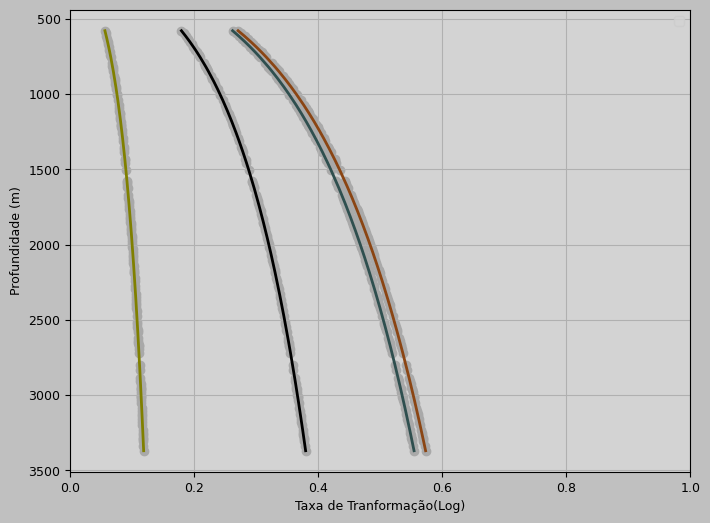

In [78]:
fig = plt.figure()
ax = fig.add_subplot()
y = df["Profundidade"].values
mdn = df["Tr_IH_Log (mdn)"].values
min = df["Tr_IH_Log (min)"].values
med = df["Tr_IH_Log (med)"].values
Ro = df["Tr_Ro_Log"].values
ax.plot(mdn, y, color='darkslategray')
ax.plot(min, y, color='olive')
ax.plot(med, y, color='saddlebrown')
ax.plot(Ro, y, color='black')
ax.scatter(mdn, y, color='darkgray')
ax.scatter(min, y, color='darkgray')
ax.scatter(med, y, color='darkgray')
ax.scatter(Ro, y, color='darkgray')
plt.legend()
plt.gca().invert_yaxis()
plt.xlim(0,1)
plt.xlabel("Taxa de Tranformação(Log)")
plt.ylabel("Profundidade (m)")
plt.style.use(custom_style)
plt.show()

#### Comparação entre os resultados de Tr (Ro x IH) 

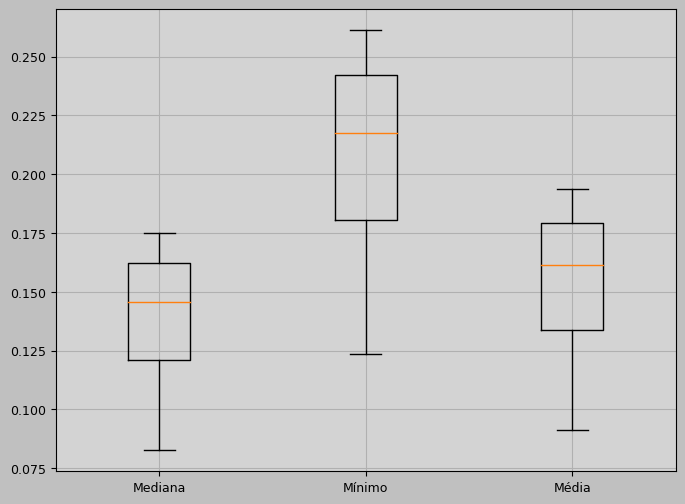

In [79]:
sub1=np.sqrt((df["Tr_IH_Log (mdn)"]-df["Tr_Ro_Log"])**2)
sub2=np.sqrt((df["Tr_IH_Log (min)"]-df["Tr_Ro_Log"])**2)
sub3=np.sqrt((df["Tr_IH_Log (med)"]-df["Tr_Ro_Log"])**2)
data=[sub1,sub2,sub3]
plt.boxplot(data)
custom_labels_x = ['Mediana', 'Mínimo', 'Média']
plt.xticks(np.arange(1, len(custom_labels_x) + 1), custom_labels_x)
plt.style.use(custom_style)
plt.show()


#### Gráfico final (output) para Taxa de Transformação

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


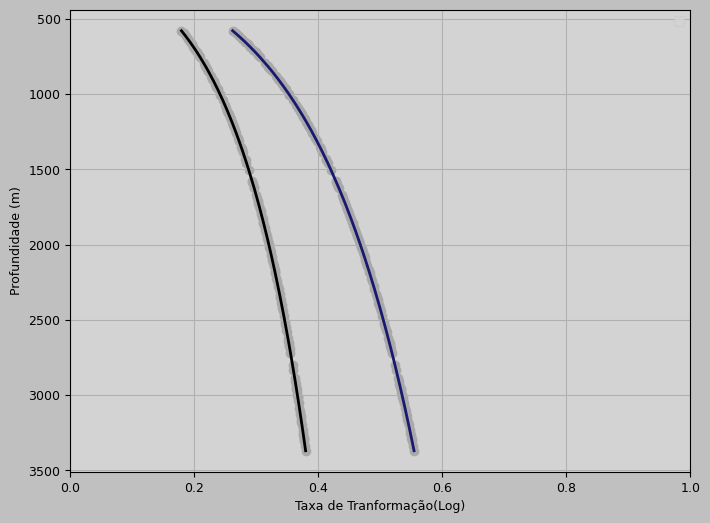

In [80]:
fig = plt.figure()
ax = fig.add_subplot()
y = df["Profundidade"].values
mdn = df["Tr_IH_Log (mdn)"].values
min = df["Tr_IH_Log (min)"].values
med = df["Tr_IH_Log (med)"].values
Ro = df["Tr_Ro_Log"].values

if sub1.mean()+sub1.std() < sub2.mean()+sub2.std() and sub1.mean()+sub1.std() < sub3.mean()+sub3.std():
    a=mdn
elif sub2.mean()+sub2.std() < sub1.mean()+sub1.std() and sub2.mean()+sub2.std() < sub3.mean()+sub3.std():
    a=min
else:
    a=med

ax.plot(a, y, color='midnightblue')
ax.plot(Ro, y, color='black')
ax.scatter(a, y, color='darkgray')
ax.scatter(Ro, y, color='darkgray')
plt.legend()
plt.gca().invert_yaxis()
plt.xlim(0,1)
plt.xlabel("Taxa de Tranformação(Log)")
plt.ylabel("Profundidade (m)")
plt.style.use(custom_style)
plt.show()

#### Diagrama de Van Krevelen

In [104]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x=df["IO"], y=df["IH"], marker='o', color='blue', s=100)
plt.xlabel("Índice de Oxigênio")
plt.ylabel("Índice de Hidrogênio")
plt.title("Diagrama de Van Krevelen")
plt.grid(True)
plt.show()

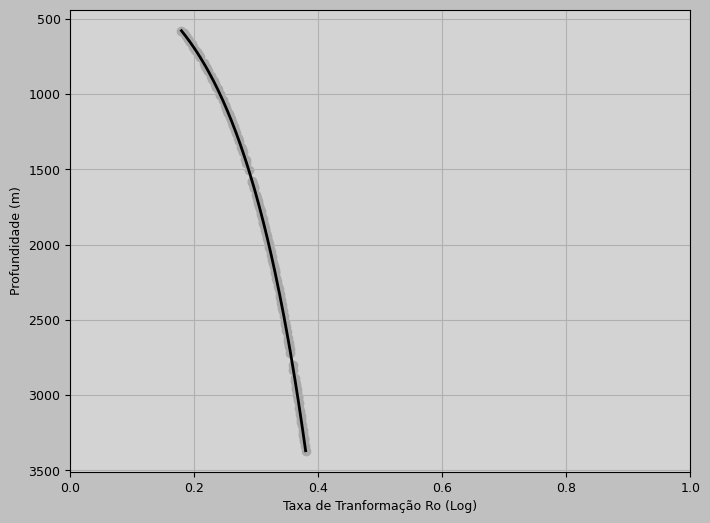

In [ ]:
# Taxa de Transformação
plt.scatter(df["Tr_Ro_Log"], df["Profundidade"], color="darkgrey")
plt.plot(df["Tr_Ro_Log"].dropna().values, df["Profundidade"].dropna().values, color="black")
plt.gca().invert_yaxis()
plt.xlim(0,1)
plt.xlabel("Taxa de Tranformação Ro (Log)")
plt.ylabel("Profundidade (m)")
plt.style.use(custom_style)
plt.show()

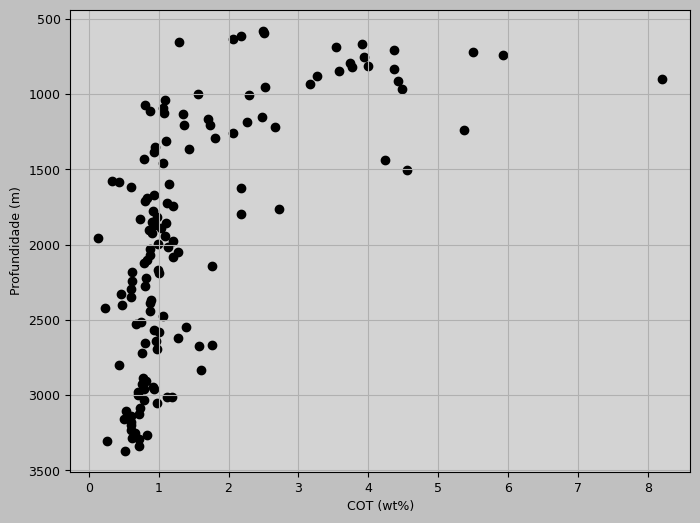

In [ ]:
#X=str(input("Parâmetro:"))
col = df["COT"]
plt.scatter(col, df["Profundidade"], color="black")
plt.gca().invert_yaxis()
plt.xlabel("COT (wt%)")
plt.ylabel("Profundidade (m)")
plt.style.use(custom_style)
plt.show()
